In [ ]:
#! pip install -q kaggle

In [ ]:
#%rm -rf '/content/lyft-motion-prediction-autonomous-vehicles/'

In [ ]:
  #!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.7-cp36-cp36m-linux_x86_64.whl

In [ ]:
# # imports pytorch
# import torch

# # imports the torch_xla package
# import torch_xla
# import torch_xla.core.xla_model as xm

In [ ]:
# device = xm.xla_device()

In [ ]:
# import os
# from google.colab import files
# if not os.path.exists('kaggle.json'):
#     files.upload()
#     !mkdir ~/.kaggle
#     !cp kaggle.json ~/.kaggle/
#     !chmod 600 ~/.kaggle/kaggle.json


In [1]:
import os 

os.makedirs('/content/lyft-motion-prediction-autonomous-vehicles/', exist_ok=True)
os.chdir('/content/lyft-motion-prediction-autonomous-vehicles/')

%cd '/content/lyft-motion-prediction-autonomous-vehicles/'
!pwd



/content
/content/lyft-motion-prediction-autonomous-vehicles


In [2]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/86.0.4240.193 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/19990/1472735/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1605743980&Signature=B%2FyJvgz4D2KK34%2Buc1%2BozZu1t7IOOPuVVNuucqNdcpp2czIO4W%2FpaMvlR6a2peJK5WAoQNQ8mW3GVRFn31Ekv%2Bj41AAY%2B9ExetexrXG9httQKLXrWFhm1wKVGJ046RCwDlPTYiTImlmyGKH6Ra3ip6ubgAW4LHMLx9PxTAV7W7%2FEhoxmQ05N7K%2BHFLLb3OCczk2Dif9BfgYXOObMJ3xRbkhA%2BrNga9QY1pFGnQMziL0rCGe%2FjBTzhK2JMARagExCeymNoh08TQ%2F45Fw2FMETaLnZGijnuSZK3MgBVR%2F5w9ZA9cqbw6sB3yp9tj2lHjPGlRbyvi%2Bmg7%2FigmZ0Vs5PtA%3D%3D&response-content-disposition=attachment%3B+filename%3Dlyft-motion-prediction-autonomous-vehicles.zip" -c -O 'lyft-motion-prediction-autonomous-vehicles.zip'

--2020-11-17 02:30:37--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/19990/1472735/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1605743980&Signature=B%2FyJvgz4D2KK34%2Buc1%2BozZu1t7IOOPuVVNuucqNdcpp2czIO4W%2FpaMvlR6a2peJK5WAoQNQ8mW3GVRFn31Ekv%2Bj41AAY%2B9ExetexrXG9httQKLXrWFhm1wKVGJ046RCwDlPTYiTImlmyGKH6Ra3ip6ubgAW4LHMLx9PxTAV7W7%2FEhoxmQ05N7K%2BHFLLb3OCczk2Dif9BfgYXOObMJ3xRbkhA%2BrNga9QY1pFGnQMziL0rCGe%2FjBTzhK2JMARagExCeymNoh08TQ%2F45Fw2FMETaLnZGijnuSZK3MgBVR%2F5w9ZA9cqbw6sB3yp9tj2lHjPGlRbyvi%2Bmg7%2FigmZ0Vs5PtA%3D%3D&response-content-disposition=attachment%3B+filename%3Dlyft-motion-prediction-autonomous-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 416 Requested range not satisfiable

    The file is a

In [ ]:
!unzip ./lyft-motion-prediction-autonomous-vehicles.zip

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
!pip -q install pymap3d==2.1.0 
!pip -q install protobuf==3.12.2 
!pip -q install transforms3d 
!pip -q install zarr 
!pip -q install ptable
 
!pip -q install --no-dependencies l5kit

In [30]:
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet50, resnet34, resnet152
import tqdm
from torch import Tensor


from l5kit.configs import load_config_data
from l5kit.data import LocalDataManager, ChunkedDataset
from l5kit.dataset import AgentDataset, EgoDataset
from l5kit.rasterization import build_rasterizer
from l5kit.evaluation import write_pred_csv, compute_metrics_csv, read_gt_csv, create_chopped_dataset
from l5kit.evaluation.chop_dataset import MIN_FUTURE_STEPS
from l5kit.evaluation.metrics import neg_multi_log_likelihood, time_displace, rmse
from l5kit.geometry import transform_points
from l5kit.visualization import PREDICTED_POINTS_COLOR, TARGET_POINTS_COLOR, draw_trajectory
from prettytable import PrettyTable
from pathlib import Path
import torch.nn.functional as F
import pandas as pd
import os
import random
import time
import gc, psutil
from IPython.display import display

In [2]:
# Memory measurement
def memory(verbose=True):
    mem = psutil.virtual_memory()
    gb = 1024*1024*1024
    if verbose:
        print('Physical memory:',
              '%.2f GB (used),'%((mem.total - mem.available) / gb),
              '%.2f GB (available)'%((mem.available) / gb), '/',
              '%.2f GB'%(mem.total / gb))
    return (mem.total - mem.available) / gb

def gc_memory(verbose=True):
    m = gc.collect()
    if verbose:
        print('GC:', m, end=' | ')
        memory()

memory();
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(42)

Physical memory: 1.07 GB (used), 24.44 GB (available) / 25.51 GB


In [3]:
DIR_INPUT = "/content/lyft-motion-prediction-autonomous-vehicles/"
DEBUG = True

In [4]:
cfg = {
    'format_version': 4,
    'model_params': {
        'model_architecture': "resnet50",
        'history_num_frames': 10,
        'history_step_size': 1,
        'history_delta_time': 0.1,
        'future_num_frames': 50,
        'future_step_size': 1,
        'future_delta_time': 0.1,
        'model_name': "model_resnet50",
        'lstm_model_name': "lstm_model_resnet50",
        'lr': 1e-3,
       'train': True,
        'predict': True
    },
    
    'raster_params': {
        'raster_size': [224, 224],
        'pixel_size': [0.5, 0.5],
        'ego_center': [0.25, 0.5],
        'map_type': 'py_semantic',
        'satellite_map_key': 'aerial_map/aerial_map.png',
        'semantic_map_key': 'semantic_map/semantic_map.pb',
        'dataset_meta_key': 'meta.json',
        'filter_agents_threshold': 0.5,
        'disable_traffic_light_faces':False
    },
    
    'train_data_loader': {
        'key': 'scenes/train.zarr',
        'batch_size': 16,
        'shuffle': True,
        'num_workers': 0
    },
    'val_data_loader': {
        'key': 'scenes/validate.zarr',
        'batch_size': 16,
        'shuffle': False,
        'num_workers': 0
    },
    'test_data_loader': {
        'key': 'scenes/test.zarr',
        'batch_size': 16,
        'shuffle': False,
        'num_workers': 0,
    },    
    'train_params': {
        'steps': 2000,
        'update_steps': 200,
        'checkpoint_steps': 200,
        'precision':False
    }
}

In [5]:

def pytorch_neg_multi_log_likelihood_batch(gt: Tensor, pred: Tensor, confidences: Tensor, avails: Tensor) -> Tensor:
    """
    Compute a negative log-likelihood for the multi-modal scenario.
    log-sum-exp trick is used here to avoid underflow and overflow, For more information about it see:
    https://en.wikipedia.org/wiki/LogSumExp#log-sum-exp_trick_for_log-domain_calculations
    https://timvieira.github.io/blog/post/2014/02/11/exp-normalize-trick/
    https://leimao.github.io/blog/LogSumExp/
    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(modes)x(time)x(2D coords)
        confidences (Tensor): array of shape (bs)x(modes) with a confidence for each mode in each sample
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    assert len(pred.shape) == 4, f"expected 3D (MxTxC) array for pred, got {pred.shape}"
    batch_size, num_modes, future_len, num_coords = pred.shape

    assert gt.shape == (batch_size, future_len, num_coords), f"expected 2D (Time x Coords) array for gt, got {gt.shape}"
    assert confidences.shape == (batch_size, num_modes), f"expected 1D (Modes) array for gt, got {confidences.shape}"
    assert torch.allclose(torch.sum(confidences, dim=1), confidences.new_ones((batch_size,))), "confidences should sum to 1"
    assert avails.shape == (batch_size, future_len), f"expected 1D (Time) array for gt, got {avails.shape}"
    # assert all data are valid
    assert torch.isfinite(pred).all(), "invalid value found in pred"
    assert torch.isfinite(gt).all(), "invalid value found in gt"
    assert torch.isfinite(confidences).all(), "invalid value found in confidences"
    assert torch.isfinite(avails).all(), "invalid value found in avails"

    # convert to (batch_size, num_modes, future_len, num_coords)
    gt = torch.unsqueeze(gt, 1)  # add modes
    avails = avails[:, None, :, None]  # add modes and cords

    # error (batch_size, num_modes, future_len)
    error = torch.sum(((gt - pred) * avails) ** 2, dim=-1)  # reduce coords and use availability

    with np.errstate(divide="ignore"):  # when confidence is 0 log goes to -inf, but we're fine with it
        # error (batch_size, num_modes)
        error = torch.log(confidences) - 0.5 * torch.sum(error, dim=-1)  # reduce time

    # use max aggregator on modes for numerical stability
    # error (batch_size, num_modes)
    max_value, _ = error.max(dim=1, keepdim=True)  # error are negative at this point, so max() gives the minimum one
    error = -torch.log(torch.sum(torch.exp(error - max_value), dim=-1, keepdim=True)) - max_value  # reduce modes
    # print("error", error)
    return torch.mean(error)


def pytorch_neg_multi_log_likelihood_single(gt: Tensor, pred: Tensor, avails: Tensor) -> Tensor:
    """

    Args:
        gt (Tensor): array of shape (bs)x(time)x(2D coords)
        pred (Tensor): array of shape (bs)x(time)x(2D coords)
        avails (Tensor): array of shape (bs)x(time) with the availability for each gt timestep
    Returns:
        Tensor: negative log-likelihood for this example, a single float number
    """
    # pred (bs)x(time)x(2D coords) --> (bs)x(mode=1)x(time)x(2D coords)
    # create confidence (bs)x(mode=1)
    batch_size, future_len, num_coords = pred.shape
    confidences = pred.new_ones((batch_size, 1))
    return pytorch_neg_multi_log_likelihood_batch(gt, pred.unsqueeze(1), confidences, avails)

In [6]:
os.environ["L5KIT_DATA_FOLDER"] = DIR_INPUT
dm = LocalDataManager(None)

In [7]:
runtime = time.strftime("%d_%b_%Y_%H_%M_%S", time.gmtime())

In [8]:
# Train DATASET
train_cfg = cfg["train_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

# Train dataset/dataloader
train_zarr = ChunkedDataset(dm.require(train_cfg["key"])).open()
train_dataset = AgentDataset(cfg, train_zarr, rasterizer)
train_dataloader = DataLoader(train_dataset,
                              shuffle=train_cfg["shuffle"],
                              batch_size=train_cfg["batch_size"],
                              num_workers=train_cfg["num_workers"])

print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [ ]:
# Test dataset
test_cfg = cfg["test_data_loader"]

# Rasterizer
rasterizer = build_rasterizer(cfg, dm)

test_zarr = ChunkedDataset(dm.require(test_cfg["key"])).open()
test_mask = np.load(f"{DIR_INPUT}/scenes/mask.npz")["arr_0"]
test_dataset = AgentDataset(cfg, test_zarr, rasterizer, agents_mask=test_mask)
test_dataloader = DataLoader(test_dataset, shuffle=test_cfg["shuffle"],
                             batch_size=test_cfg["batch_size"], num_workers=test_cfg["num_workers"])
print(test_dataset)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: you're running with a custom agents_mask
  if __name__ == '__main__':


+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   11314    |  1131400   |  88594921  |    7854144    |      31.43      |        100.00        |        78.31         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


RESNET BASED MODELS

In [ ]:
class LyftMultiModel(nn.Module):

    def __init__(self, cfg: Dict, num_modes=3):
        super().__init__()

        architecture = cfg["model_params"]["model_architecture"]
        backbone = eval(architecture)(pretrained=True, progress=True)
        self.backbone = backbone

        num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
        num_in_channels = 3 + num_history_channels

        self.backbone.conv1 = nn.Conv2d(
            num_in_channels,
            self.backbone.conv1.out_channels,
            kernel_size=self.backbone.conv1.kernel_size,
            stride=self.backbone.conv1.stride,
            padding=self.backbone.conv1.padding,
            bias=False,
        )

        if architecture == "resnet50":
            backbone_out_features = 2048
        else:
            backbone_out_features = 512

        # X, Y coords for the future positions (output shape: batch_sizex50x2)
        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        # You can add more layers here.
        self.head = nn.Sequential(
            # nn.Dropout(0.2),
            nn.Linear(in_features=backbone_out_features, out_features=4096),
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(4096, out_features=self.num_preds + num_modes)

    def forward(self, x):
        x = self.backbone.conv1(x)
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)
        x = torch.flatten(x, 1)

        x = self.head(x)
        x = self.logit(x)

        # pred (batch_size)x(modes)x(time)x(2D coords)
        # confidences (batch_size)x(modes)
        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences

In [ ]:
def forward(data, model, device, criterion=pytorch_neg_multi_log_likelihood_batch, compute_loss=True):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    preds, confidences = model(inputs)
    # skip compute loss if we are doing prediction
    loss = criterion(targets, preds, confidences, target_availabilities) if compute_loss else 0
    return loss, preds, confidences

In [ ]:
# ==== INIT MODEL=================
model_name = cfg["model_params"]["model_name"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model = LyftMultiModel(cfg)

#load weight if there is a pretrained model
# weight_path = f"{model_name}_final.pth"
# if weight_path:
#     model.load_state_dict(torch.load(weight_path))
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg["model_params"]["lr"])

# load weight if there is a pretrained model
# opt_weight_path = f"{model_name}_optimizer_final.pth"
# if opt_weight_path:
#     optimizer.load_state_dict(torch.load(opt_weight_path))

print(f'device {device}')

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth



device cuda:0


In [ ]:
%%time
if cfg["model_params"]["train"]:
    tr_it = iter(train_dataloader)
    n_steps = cfg["train_params"]["steps"]
    progress_bar = tqdm.notebook.tqdm(range(1, 1 + n_steps), mininterval=5.)
    losses = []
    iterations = []
    metrics = []
    memorys = []
    times = []
    model_name = cfg["model_params"]["model_name"]
    update_steps = cfg['train_params']['update_steps']
    checkpoint_steps = cfg['train_params']['checkpoint_steps']
    t_start = time.time()
    torch.set_grad_enabled(True)
        
    for i in progress_bar:
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)
        model.train()  

        optimizer.zero_grad()

        if cfg["train_params"]["precision"] == True:
            scaler = torch.cuda.amp.GradScaler()
            with torch.cuda.amp.autocast():
                loss, _, _ = forward(data, model, device)

            # Scales the loss, and calls backward()
            # to create scaled gradients
            scaler.scale(loss).backward()

            # Unscales gradients and calls
            # or skips optimizer.step()
            scaler.step(optimizer)

            # Updates the scale for next iteration
            scaler.update()
        else:
            
            loss, _, _ = forward(data, model, device)
            loss.backward()
            optimizer.step()
        
        loss_v = loss.item()
        losses.append(loss_v)
        
        if i % update_steps == 0:
            mean_losses = np.mean(losses)
            timespent = (time.time() - t_start) / 60
            print('i: %5d'%i,
                  'loss: %10.5f'%loss_v, 'loss(avg): %10.5f'%mean_losses, 
                  '%.2fmins'%timespent, end=' | ')
            mem = memory()
            if i % checkpoint_steps == 0:
                torch.save(model.state_dict(), f'{model_name}_{i}.pth')
                torch.save(optimizer.state_dict(), f'{model_name}_optimizer_{i}.pth')
            iterations.append(i)
            metrics.append(mean_losses)
            memorys.append(mem)
            times.append(timespent)

    torch.save(model.state_dict(), f'{model_name}_final.pth')
    torch.save(optimizer.state_dict(), f'{model_name}_optimizer_final.pth')
    results = pd.DataFrame({
        'iterations': iterations, 
        'metrics (avg)': metrics,
        'elapsed_time (mins)': times,
        'memory (GB)': memorys,
    })
    results.to_csv(f'train_metrics_{model_name}_{n_steps}_{runtime}.csv', index=False)
    print(f'Total training time is {(time.time() - t_start) / 60} mins')
    memory()
    display(results)

i:   200 loss:  577.45984 loss(avg):  866.15511 3.49mins | Physical memory: 2.90 GB (used), 22.62 GB (available) / 25.51 GB
i:   400 loss:  185.38409 loss(avg):  625.39367 6.86mins | Physical memory: 2.89 GB (used), 22.62 GB (available) / 25.51 GB
i:   600 loss:  516.49487 loss(avg):  533.44016 10.19mins | Physical memory: 3.00 GB (used), 22.51 GB (available) / 25.51 GB
i:   800 loss:  120.20500 loss(avg):  466.17238 13.56mins | Physical memory: 3.05 GB (used), 22.47 GB (available) / 25.51 GB
i:  1000 loss:   90.28430 loss(avg):  435.86981 16.95mins | Physical memory: 3.09 GB (used), 22.42 GB (available) / 25.51 GB
i:  1200 loss:   56.18144 loss(avg):  404.77605 20.34mins | Physical memory: 3.22 GB (used), 22.30 GB (available) / 25.51 GB
i:  1400 loss:  192.80875 loss(avg):  376.75377 23.70mins | Physical memory: 3.27 GB (used), 22.24 GB (available) / 25.51 GB
i:  1600 loss:   85.28721 loss(avg):  359.40427 27.00mins | Physical memory: 3.26 GB (used), 22.25 GB (available) / 25.51 GB
i:

,iterations,metrics (avg),elapsed_time (mins),memory (GB)
0,200,866.155108,3.485628,2.895405
1,400,625.393667,6.863407,2.890755
2,600,533.440161,10.191877,3.003078
3,800,466.172384,13.561766,3.045273
4,1000,435.869814,16.949532,3.094471
5,1200,404.776051,20.335634,3.215393
6,1400,376.753771,23.702010,3.268768
7,1600,359.404274,27.003680,3.261696
8,1800,344.519190,30.308088,3.290138
9,2000,333.695344,33.578216,3.283207


CPU times: user 42min 31s, sys: 56min 19s, total: 1h 38min 51s
Wall time: 33min 37s


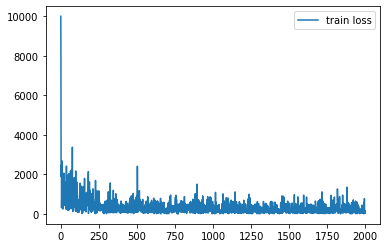

In [ ]:
plt.plot(np.arange(len(losses)), losses, label="train loss")
plt.legend()
plt.show()

**VALIDATION SET**

In [61]:
# ===== GENERATE AND LOAD CHOPPED DATASET
num_frames_to_chop = 100
eval_cfg = cfg["val_data_loader"]
eval_base_path = create_chopped_dataset(dm.require(eval_cfg["key"]), cfg["raster_params"]["filter_agents_threshold"], 
                              num_frames_to_chop, cfg["model_params"]["future_num_frames"], MIN_FUTURE_STEPS)


copying: 100%|██████████| 16220/16220 [06:16<00:00, 43.03it/s]
/usr/local/lib/python3.6/dist-packages/l5kit/evaluation/extract_ground_truth.py:59: RuntimeWarning: you're running with a custom agents_mask
  dataset = AgentDataset(cfg=cfg, zarr_dataset=zarr_dataset, rasterizer=rasterizer, agents_mask=agents_mask)
extracting GT: 100%|██████████| 94694/94694 [18:25<00:00, 85.67it/s]


In [62]:
eval_zarr_path = str(Path(eval_base_path) / Path(dm.require(eval_cfg["key"])).name)
eval_mask_path = str(Path(eval_base_path) / "mask.npz")
eval_gt_path = str(Path(eval_base_path) / "gt.csv")

eval_zarr = ChunkedDataset(eval_zarr_path).open()
eval_mask = np.load(eval_mask_path)["arr_0"]
# ===== INIT DATASET AND LOAD MASK
eval_dataset = AgentDataset(cfg, eval_zarr, rasterizer, agents_mask=eval_mask)
eval_dataloader = DataLoader(eval_dataset, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"], 
                             num_workers=eval_cfg["num_workers"])
print(eval_dataset)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: you're running with a custom agents_mask
  


+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16220    |  1622000   | 125423254  |    11733321   |      45.06      |        100.00        |        77.33         |        10.00         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [ ]:
# ==== EVAL LOOP
%%time
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
confidences_list = []
agent_ids = []
memorys_pred = []
t0 = time.time()
times_pred = []
iterations_pred = []

for i, data in enumerate(tqdm.notebook.tqdm(eval_dataloader, mininterval=5.)):
    
    _, preds, confidences = forward(data, model, device, compute_loss=False)

    preds = torch.einsum('bmti,bji->bmtj', 
                          preds.double(), 
                          data["world_from_agent"].to(device)[:, :2, :2]).cpu().numpy()

    future_coords_offsets_pd.append(preds.copy())
    confidences_list.append(confidences.cpu().numpy().copy())
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy()) 
    
    if i%50 == 0:
        t = ((time.time() - t0) / 60)
        print('%4d'%i, '%6.2fmins'%t, end=' | ')
        mem = memory()
        iterations_pred.append(i)
        memorys_pred.append(mem)
        times_pred.append(t)

    if i == 250:
      break;
print('Total timespent: %6.2fmins'%((time.time() - t0) / 60))
memory()




   0   0.01mins | Physical memory: 5.89 GB (used), 19.62 GB (available) / 25.51 GB
  50   0.69mins | Physical memory: 5.89 GB (used), 19.62 GB (available) / 25.51 GB
 100   1.37mins | Physical memory: 5.89 GB (used), 19.62 GB (available) / 25.51 GB
 150   1.99mins | Physical memory: 5.89 GB (used), 19.62 GB (available) / 25.51 GB
 200   2.63mins | Physical memory: 5.90 GB (used), 19.62 GB (available) / 25.51 GB
 250   3.24mins | Physical memory: 5.91 GB (used), 19.60 GB (available) / 25.51 GB
Total timespent:   3.24mins
Physical memory: 5.91 GB (used), 19.60 GB (available) / 25.51 GB
CPU times: user 4min 10s, sys: 5min 39s, total: 9min 50s
Wall time: 3min 14s


In [ ]:
pred_path = f"{DIR_INPUT}/resnetpred.csv"

write_pred_csv(
    pred_path,
    timestamps=np.concatenate(timestamps),
    track_ids=np.concatenate(agent_ids),
    coords=np.concatenate(future_coords_offsets_pd),
    confs=np.concatenate(confidences_list),
)


In [ ]:
from collections import OrderedDict, defaultdict

from l5kit.evaluation.csv_utils import read_gt_csv, read_pred_csv
from l5kit.evaluation.metrics import metric_signature

ground_truth_path = eval_gt_path
inference_output_path = pred_path
metrics = [neg_multi_log_likelihood, rmse]

ground_truth = OrderedDict()
inference = OrderedDict()

for el in read_gt_csv(ground_truth_path):
    ground_truth[el["track_id"] + el["timestamp"]] = el
for el in read_pred_csv(inference_output_path):
    inference[el["track_id"] + el["timestamp"]] = el

metrics_dict = defaultdict(list)

for key, ground_truth_value in ground_truth.items():
    gt_coord = ground_truth_value["coord"]
    avail = ground_truth_value["avail"]
    if key in inference:
      pred_coords = inference[key].get("coords", None)
      conf = inference[key].get("conf", None)
      for metric in metrics:
          metrics_dict[metric.__name__].append(metric(gt_coord, pred_coords, conf, avail))

# compute average of each metric
comp_metrics = {metric_name: np.mean(values, axis=0) for metric_name, values in metrics_dict.items()}
print(comp_metrics)


{'neg_multi_log_likelihood': 267.85879771109785, 'rmse': 1.8545260322247716}


In [ ]:
# del model
# torch.cuda.empty_cache()

**LSTM MODELS**

In [45]:
class Encoder(nn.Module):

    # def __init__(self, cfg: Dict, encode_dim, num_modes=3):
    #     super().__init__()

    #     architecture = cfg["model_params"]["model_architecture"]
    #     backbone = resnet152(pretrained=True, progress=True)
    #     self.backbone = backbone

    #     # num_history_channels = (cfg["model_params"]["history_num_frames"] + 1) * 2
    #     # num_in_channels = 3 + num_history_channels
    #     num_in_channels = 1

    #     self.backbone.conv1 = nn.Conv2d(
    #         num_in_channels,
    #         self.backbone.conv1.out_channels,
    #         kernel_size=self.backbone.conv1.kernel_size,
    #         stride=self.backbone.conv1.stride,
    #         padding=self.backbone.conv1.padding,
    #         bias=False,
    #     )

    #     backbone_out_features = 2048

    #     # You can add more layers here.
    #     self.head = nn.Sequential(
    #         # nn.Dropout(0.2),
    #         nn.Linear(in_features=backbone_out_features, out_features=encode_dim),
    #     )

 
    # def forward(self, x):
    #     with torch.no_grad():
    #       x = self.backbone.conv1(x)
    #       x = self.backbone.bn1(x)
    #       x = self.backbone.relu(x)
    #       x = self.backbone.maxpool(x)

    #       x = self.backbone.layer1(x)
    #       x = self.backbone.layer2(x)
    #       x = self.backbone.layer3(x)
    #       x = self.backbone.layer4(x)

    #       x = self.backbone.avgpool(x)
    #       x = torch.flatten(x, 1)

    #     return self.head(x)


    def __init__(self, cfg, latent_dim):
        super(Encoder, self).__init__()
        resnet = resnet34(pretrained=True)
        self.conv1 = nn.Conv2d(
            1,
            resnet.conv1.out_channels,
            kernel_size=resnet.conv1.kernel_size,
            stride=resnet.conv1.stride,
            padding=resnet.conv1.padding,
            bias=False,
        )
        self.feature_extractor = nn.Sequential(*list(resnet.children())[1:-1])
        self.final = nn.Sequential(
            nn.Linear(resnet.fc.in_features, latent_dim),
            # nn.BatchNorm1d(latent_dim)
        )

    def forward(self, x):
        with torch.no_grad():
          x = self.conv1(x)
          x = self.feature_extractor(x)
        x = x.view(x.size(0), -1)
        return self.final(x)


In [46]:
# class LSTM(nn.Module):
#     def __init__(self, latent_dim, num_layers, hidden_dim, bidirectional):
#         super(LSTM, self).__init__()
#         self.lstm = nn.LSTM(latent_dim, hidden_dim, num_layers, batch_first=True, bidirectional=bidirectional)
#         # self.hidden_state = None

#     def reset_hidden_state(self):
#         self.hidden_state = None

#     def forward(self, x):
#         x, self.hidden_state = self.lstm(x, self.hidden_state)
#         return x


In [57]:
class ConvLSTM(nn.Module):
    def __init__(
        self, cfg=cfg, latent_dim=512, lstm_layers=2, hidden_dim=512, bidirectional=True, num_modes=3, logit_size=1024, encode_dim=512,
    ):
        super(ConvLSTM, self).__init__()
        self.encoder = Encoder(cfg, encode_dim)
        self.lstm = nn.LSTM(latent_dim, hidden_size=hidden_dim, num_layers=lstm_layers, bidirectional=bidirectional)

        self.future_len = cfg["model_params"]["future_num_frames"]
        num_targets = 2 * self.future_len

        self.head = nn.Sequential(
            nn.Linear(2 * hidden_dim if bidirectional else hidden_dim, logit_size),
        )

        self.num_preds = num_targets * num_modes
        self.num_modes = num_modes

        self.logit = nn.Linear(logit_size, out_features=self.num_preds + num_modes)

    def forward(self, x):
        batch_size, seq_length, h, w = x.shape
        x = x.view(batch_size *seq_length, 1, h, w)
        x = self.encoder(x)
        x = x.view(batch_size, seq_length, -1)
        x, _ = self.lstm(x)
 
        x = x[:, -1, :]
        x = self.head(x)
        x = self.logit(x)

        bs, _ = x.shape
        pred, confidences = torch.split(x, self.num_preds, dim=1)
        pred = pred.view(bs, self.num_modes, self.future_len, 2)
        assert confidences.shape == (bs, self.num_modes)
        confidences = torch.softmax(confidences, dim=1)
        return pred, confidences



In [58]:
def forward(data, model, device, criterion=pytorch_neg_multi_log_likelihood_batch, compute_loss=True):
    inputs = data["image"].to(device)
    target_availabilities = data["target_availabilities"].to(device)
    targets = data["target_positions"].to(device)
    # Forward pass
    preds, confidences = model(inputs)
    # skip compute loss if we are doing prediction
    loss = criterion(targets, preds, confidences, target_availabilities) if compute_loss else 0
    return loss, preds, confidences

In [59]:
model_name = cfg["model_params"]["lstm_model_name"]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ConvLSTM()

model.to(device)
optimizer = optim.Adam(model.parameters(), lr=cfg["model_params"]["lr"])


In [60]:
%%time
if cfg["model_params"]["train"]:
    tr_it = iter(train_dataloader)
    n_steps = cfg["train_params"]["steps"]
    progress_bar = tqdm.notebook.tqdm(range(1, 1 + n_steps), mininterval=5.)
    losses = []
    iterations = []
    metrics = []
    memorys = []
    times = []
    model_name = cfg["model_params"]["lstm_model_name"]
    update_steps = cfg['train_params']['update_steps']
    checkpoint_steps = cfg['train_params']['checkpoint_steps']
    t_start = time.time()
    torch.set_grad_enabled(True)
        
    for i in progress_bar:
        try:
            data = next(tr_it)
        except StopIteration:
            tr_it = iter(train_dataloader)
            data = next(tr_it)
        # Reset LSTM hidden state
        # model.lstm.reset_hidden_state()
        model.train()  

        optimizer.zero_grad()

        if cfg["train_params"]["precision"] == True:
            scaler = torch.cuda.amp.GradScaler()
            with torch.cuda.amp.autocast():
                loss, _, _ = forward(data, model, device)

            # Scales the loss, and calls backward()
            # to create scaled gradients
            scaler.scale(loss).backward(retain_graph=True)

            # Unscales gradients and calls
            # or skips optimizer.step()
            scaler.step(optimizer)

            # Updates the scale for next iteration
            scaler.update()
        else:
            
            loss, _, _ = forward(data, model, device)
            loss.backward(retain_graph=True)
            optimizer.step()
        
        loss_v = loss.item()
        losses.append(loss_v)
        
        if i % update_steps == 0:
            mean_losses = np.mean(losses)
            timespent = (time.time() - t_start) / 60
            print('i: %5d'%i,
                  'loss: %10.5f'%loss_v, 'loss(avg): %10.5f'%mean_losses, 
                  '%.2fmins'%timespent, end=' | ')
            mem = memory()
            if i % checkpoint_steps == 0:
                torch.save(model.state_dict(), f'{model_name}_{i}.pth')
                torch.save(optimizer.state_dict(), f'{model_name}_optimizer_{i}.pth')
            iterations.append(i)
            metrics.append(mean_losses)
            memorys.append(mem)
            times.append(timespent)

    torch.save(model.state_dict(), f'{model_name}_final.pth')
    torch.save(optimizer.state_dict(), f'{model_name}_optimizer_final.pth')
    results = pd.DataFrame({
        'iterations': iterations, 
        'metrics (avg)': metrics,
        'elapsed_time (mins)': times,
        'memory (GB)': memorys,
    })
    results.to_csv(f'train_metrics_{model_name}_{n_steps}_{runtime}.csv', index=False)
    print(f'Total training time is {(time.time() - t_start) / 60} mins')
    memory()
    display(results)

i:   200 loss:   93.15427 loss(avg):  612.43413 3.63mins | Physical memory: 6.67 GB (used), 18.84 GB (available) / 25.51 GB
i:   400 loss:  856.94031 loss(avg):  522.13428 7.23mins | Physical memory: 6.71 GB (used), 18.80 GB (available) / 25.51 GB
i:   600 loss:  394.42581 loss(avg):  495.46299 10.89mins | Physical memory: 6.78 GB (used), 18.74 GB (available) / 25.51 GB
i:   800 loss:  217.36792 loss(avg):  475.20347 14.50mins | Physical memory: 6.78 GB (used), 18.73 GB (available) / 25.51 GB
i:  1000 loss:  422.73627 loss(avg):  463.31604 18.12mins | Physical memory: 6.77 GB (used), 18.74 GB (available) / 25.51 GB
i:  1200 loss:  497.06964 loss(avg):  454.55755 21.72mins | Physical memory: 6.77 GB (used), 18.74 GB (available) / 25.51 GB
i:  1400 loss:  265.01135 loss(avg):  444.45469 25.33mins | Physical memory: 6.92 GB (used), 18.59 GB (available) / 25.51 GB
i:  1600 loss:  390.22900 loss(avg):  439.52889 28.93mins | Physical memory: 6.89 GB (used), 18.62 GB (available) / 25.51 GB
i:

,iterations,metrics (avg),elapsed_time (mins),memory (GB)
0,200,612.434133,3.634513,6.673695
1,400,522.134279,7.232908,6.707909
2,600,495.462992,10.888200,6.777145
3,800,475.203473,14.499517,6.782177
4,1000,463.316038,18.116840,6.774254
5,1200,454.557554,21.721989,6.773754
6,1400,444.454693,25.331940,6.921513
7,1600,439.528887,28.934413,6.891598
8,1800,435.758286,32.521109,6.954166
9,2000,430.917158,36.115546,6.939121


CPU times: user 44min 24s, sys: 56min 39s, total: 1h 41min 4s
Wall time: 36min 8s
Parser   : 226 ms


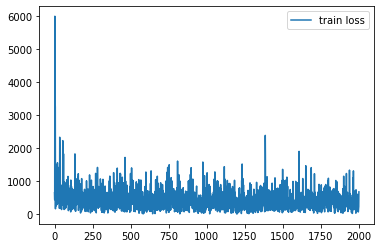

In [63]:
plt.plot(np.arange(len(losses)), losses, label="train loss")
plt.legend()
plt.show()

LSTM Evaluation

In [64]:
# ==== EVAL LOOP
%%time
model.eval()
torch.set_grad_enabled(False)

# store information for evaluation
future_coords_offsets_pd = []
timestamps = []
confidences_list = []
agent_ids = []
memorys_pred = []
t0 = time.time()
times_pred = []
iterations_pred = []

for i, data in enumerate(tqdm.notebook.tqdm(eval_dataloader, mininterval=5.)):
    
    _, preds, confidences = forward(data, model, device, compute_loss=False)

    preds = torch.einsum('bmti,bji->bmtj', 
                          preds.double(), 
                          data["world_from_agent"].to(device)[:, :2, :2]).cpu().numpy()

    future_coords_offsets_pd.append(preds.copy())
    confidences_list.append(confidences.cpu().numpy().copy())
    timestamps.append(data["timestamp"].numpy().copy())
    agent_ids.append(data["track_id"].numpy().copy()) 
    
    if i%50 == 0:
        t = ((time.time() - t0) / 60)
        print('%4d'%i, '%6.2fmins'%t, end=' | ')
        mem = memory()
        iterations_pred.append(i)
        memorys_pred.append(mem)
        times_pred.append(t)

    if i == 250:
      break;
print('Total timespent: %6.2fmins'%((time.time() - t0) / 60))
memory()




   0   0.02mins | Physical memory: 5.58 GB (used), 19.93 GB (available) / 25.51 GB
  50   0.86mins | Physical memory: 5.55 GB (used), 19.96 GB (available) / 25.51 GB
 100   1.70mins | Physical memory: 5.56 GB (used), 19.96 GB (available) / 25.51 GB
 150   2.49mins | Physical memory: 5.56 GB (used), 19.96 GB (available) / 25.51 GB
 200   3.32mins | Physical memory: 5.56 GB (used), 19.95 GB (available) / 25.51 GB
 250   4.07mins | Physical memory: 5.56 GB (used), 19.95 GB (available) / 25.51 GB
Total timespent:   4.07mins
Physical memory: 5.56 GB (used), 19.95 GB (available) / 25.51 GB
CPU times: user 4min 58s, sys: 6min 29s, total: 11min 27s
Wall time: 4min 4s


In [65]:
pred_path = f"{DIR_INPUT}/lstmpred.csv"

write_pred_csv(
    pred_path,
    timestamps=np.concatenate(timestamps),
    track_ids=np.concatenate(agent_ids),
    coords=np.concatenate(future_coords_offsets_pd),
    confs=np.concatenate(confidences_list),
)


In [66]:
from collections import OrderedDict, defaultdict

from l5kit.evaluation.csv_utils import read_gt_csv, read_pred_csv
from l5kit.evaluation.metrics import metric_signature

ground_truth_path = eval_gt_path
inference_output_path = pred_path
metrics = [neg_multi_log_likelihood, rmse]

ground_truth = OrderedDict()
inference = OrderedDict()

for el in read_gt_csv(ground_truth_path):
    ground_truth[el["track_id"] + el["timestamp"]] = el
for el in read_pred_csv(inference_output_path):
    inference[el["track_id"] + el["timestamp"]] = el

metrics_dict = defaultdict(list)

for key, ground_truth_value in ground_truth.items():
    gt_coord = ground_truth_value["coord"]
    avail = ground_truth_value["avail"]
    if key in inference:
      pred_coords = inference[key].get("coords", None)
      conf = inference[key].get("conf", None)
      for metric in metrics:
          metrics_dict[metric.__name__].append(metric(gt_coord, pred_coords, conf, avail))

# compute average of each metric
comp_metrics = {metric_name: np.mean(values, axis=0) for metric_name, values in metrics_dict.items()}
print(comp_metrics)

{'neg_multi_log_likelihood': 480.86961051587724, 'rmse': 2.7274378384082825}


In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(model)

+---------------------------------------------------+------------+
|                      Modules                      | Parameters |
+---------------------------------------------------+------------+
|                encoder.conv1.weight               |    3136    |
|         encoder.feature_extractor.0.weight        |     64     |
|          encoder.feature_extractor.0.bias         |     64     |
|     encoder.feature_extractor.3.0.conv1.weight    |    4096    |
|      encoder.feature_extractor.3.0.bn1.weight     |     64     |
|       encoder.feature_extractor.3.0.bn1.bias      |     64     |
|     encoder.feature_extractor.3.0.conv2.weight    |   36864    |
|      encoder.feature_extractor.3.0.bn2.weight     |     64     |
|       encoder.feature_extractor.3.0.bn2.bias      |     64     |
|     encoder.feature_extractor.3.0.conv3.weight    |   16384    |
|      encoder.feature_extractor.3.0.bn3.weight     |    256     |
|       encoder.feature_extractor.3.0.bn3.bias      |    256  

62526703

**TEST SET PREDICTIONS**

In [ ]:
%%time
if cfg["model_params"]["predict"]:
    
    model.eval()
    torch.set_grad_enabled(False)

    # store information for evaluation
    future_coords_offsets_pd = []
    timestamps = []
    confidences_list = []
    agent_ids = []
    memorys_pred = []
    t0 = time.time()
    times_pred = []
    iterations_pred = []

    for i, data in enumerate(tqdm.notebook.tqdm(test_dataloader, mininterval=5.)):
        
        _, preds, confidences = forward(data, model, device, compute_loss=False)
    
        preds = torch.einsum('bmti,bji->bmtj', 
                             preds.double(), 
                             data["world_from_agent"].to(device)[:, :2, :2]).cpu().numpy()
    
        future_coords_offsets_pd.append(preds.copy())
        confidences_list.append(confidences.cpu().numpy().copy())
        timestamps.append(data["timestamp"].numpy().copy())
        agent_ids.append(data["track_id"].numpy().copy()) 
        
        if i%50 == 0:
            t = ((time.time() - t0) / 60)
            print('%4d'%i, '%6.2fmins'%t, end=' | ')
            mem = memory()
            iterations_pred.append(i)
            memorys_pred.append(mem)
            times_pred.append(t)

    print('Total timespent: %6.2fmins'%((time.time() - t0) / 60))
    memory()

In [ ]:
%%time
# create submission to submit to Kaggle
pred_path = 'submission.csv'
write_pred_csv(
    pred_path,
    timestamps=np.concatenate(timestamps),
    track_ids=np.concatenate(agent_ids),
    coords=np.concatenate(future_coords_offsets_pd),
    confs=np.concatenate(confidences_list),
)

In [ ]:
!kaggle datasets version -p /content/lyft-motion-prediction-autonomous-vehicles/submission.csv -m "Updated data"

In [ ]:
! kaggle datasets init -p  /content/lyft

In [ ]:
! kaggle datasets create -p /content/lyft